=== LOADING FULL DATASET ===
BTCUSD: 1,012,793 rows (2016-01-01 to 2025-08-17)
ETHUSD: 971,628 rows (2016-05-22 to 2025-08-17)
SOLUSD: 438,557 rows (2021-06-16 to 2025-08-17)
XRPUSD: 220,633 rows (2023-07-13 to 2025-08-17)

Successfully loaded 4 symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']

=== ALIGNING TIMESTAMPS ===
Aligned dataset: 220,613 rows from 2023-07-13 to 2025-08-17
Daily dataset: 767 days

=== EXPLORATORY DATA ANALYSIS ===
Returns dataset: 766 observations after cleaning
NaN values in returns matrix: 1
Inf values in returns matrix: 0

Daily Return Correlations:
BTCUSD-ETHUSD: 0.777
BTCUSD-SOLUSD: 0.706
BTCUSD-XRPUSD: 0.551
ETHUSD-SOLUSD: 0.658
ETHUSD-XRPUSD: 0.554
SOLUSD-XRPUSD: 0.506

Stationarity Tests (ADF p-values):
BTCUSD log-price: p=0.8045 → non-stationary
ETHUSD log-price: p=0.6178 → non-stationary
SOLUSD log-price: p=0.2456 → non-stationary
XRPUSD log-price: p=0.9625 → non-stationary

Cointegration Tests:
BTCUSD-ETHUSD: p=0.8230 → not cointegrated
BTCUSD-SOLUS

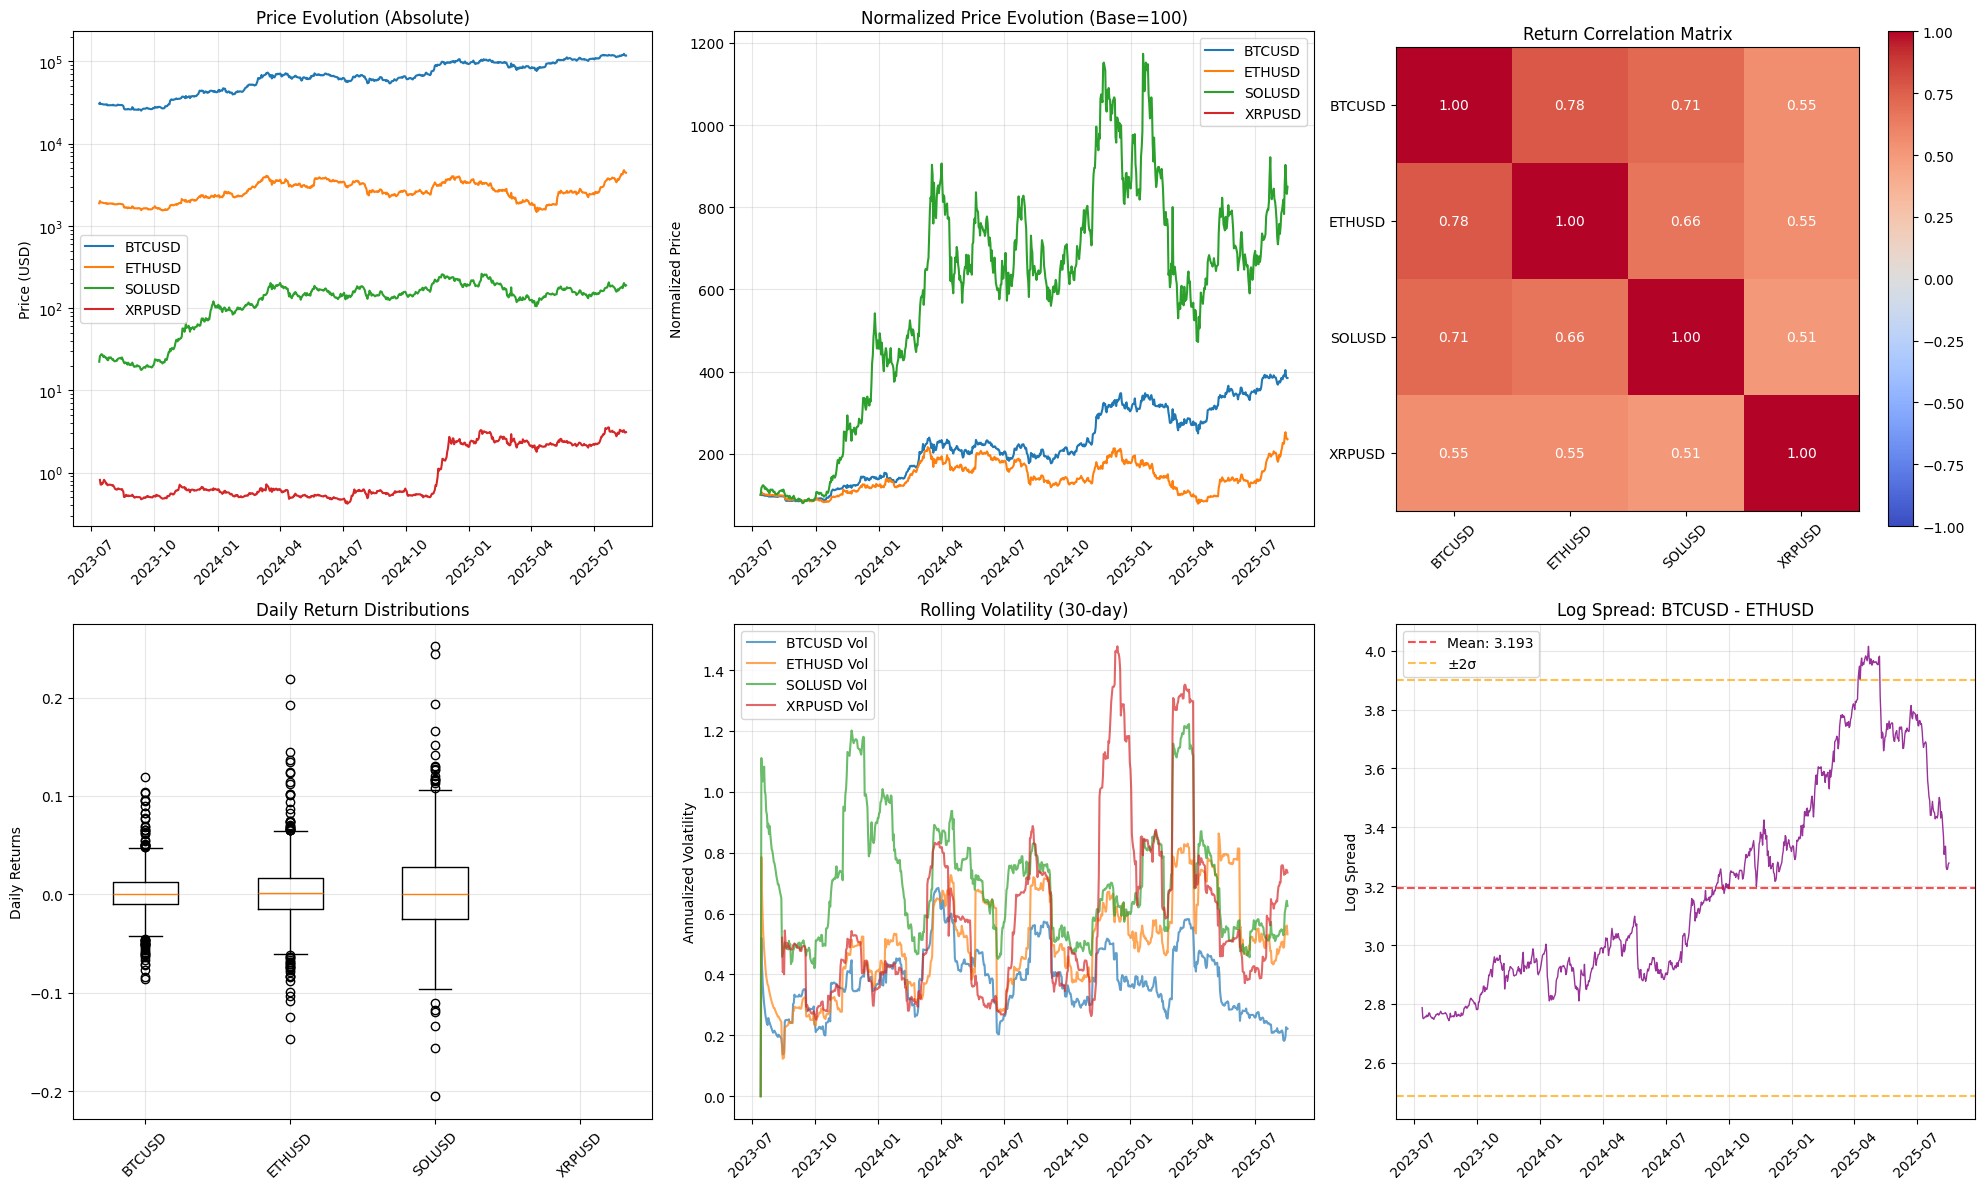


=== FEATURE ENGINEERING WITH TRAIN/TEST SPLIT ===
Using cointegrated pair: BTCUSD - ETHUSD
Feature dataset shape: (742, 28)

Train set: 519 observations (2023-08-06 to 2025-01-05)
Test set: 223 observations (2025-01-06 to 2025-08-16)

Train set: 519 observations (2023-08-06 to 2025-01-05)
Test set: 223 observations (2025-01-06 to 2025-08-16)

=== MODEL TRAINING ===
Training R²: 0.0287
Test R²: -0.0530
Training RMSE: 0.0190
Test RMSE: 0.0277

Feature Importance (by absolute coefficient):
spread_momentum: -0.2537
momentum_lag1: 0.1777
spread_vol_short: -0.1541
spread_ret_lag2: 0.0992
spread_ret_lag1: 0.0910
z_spread: 0.0611
z_ratio: -0.0588
momentum_3d: -0.0534
momentum_7d: 0.0397
z_spread_lag1: -0.0033
vol_ratio: -0.0021
vol_regime: 0.0015


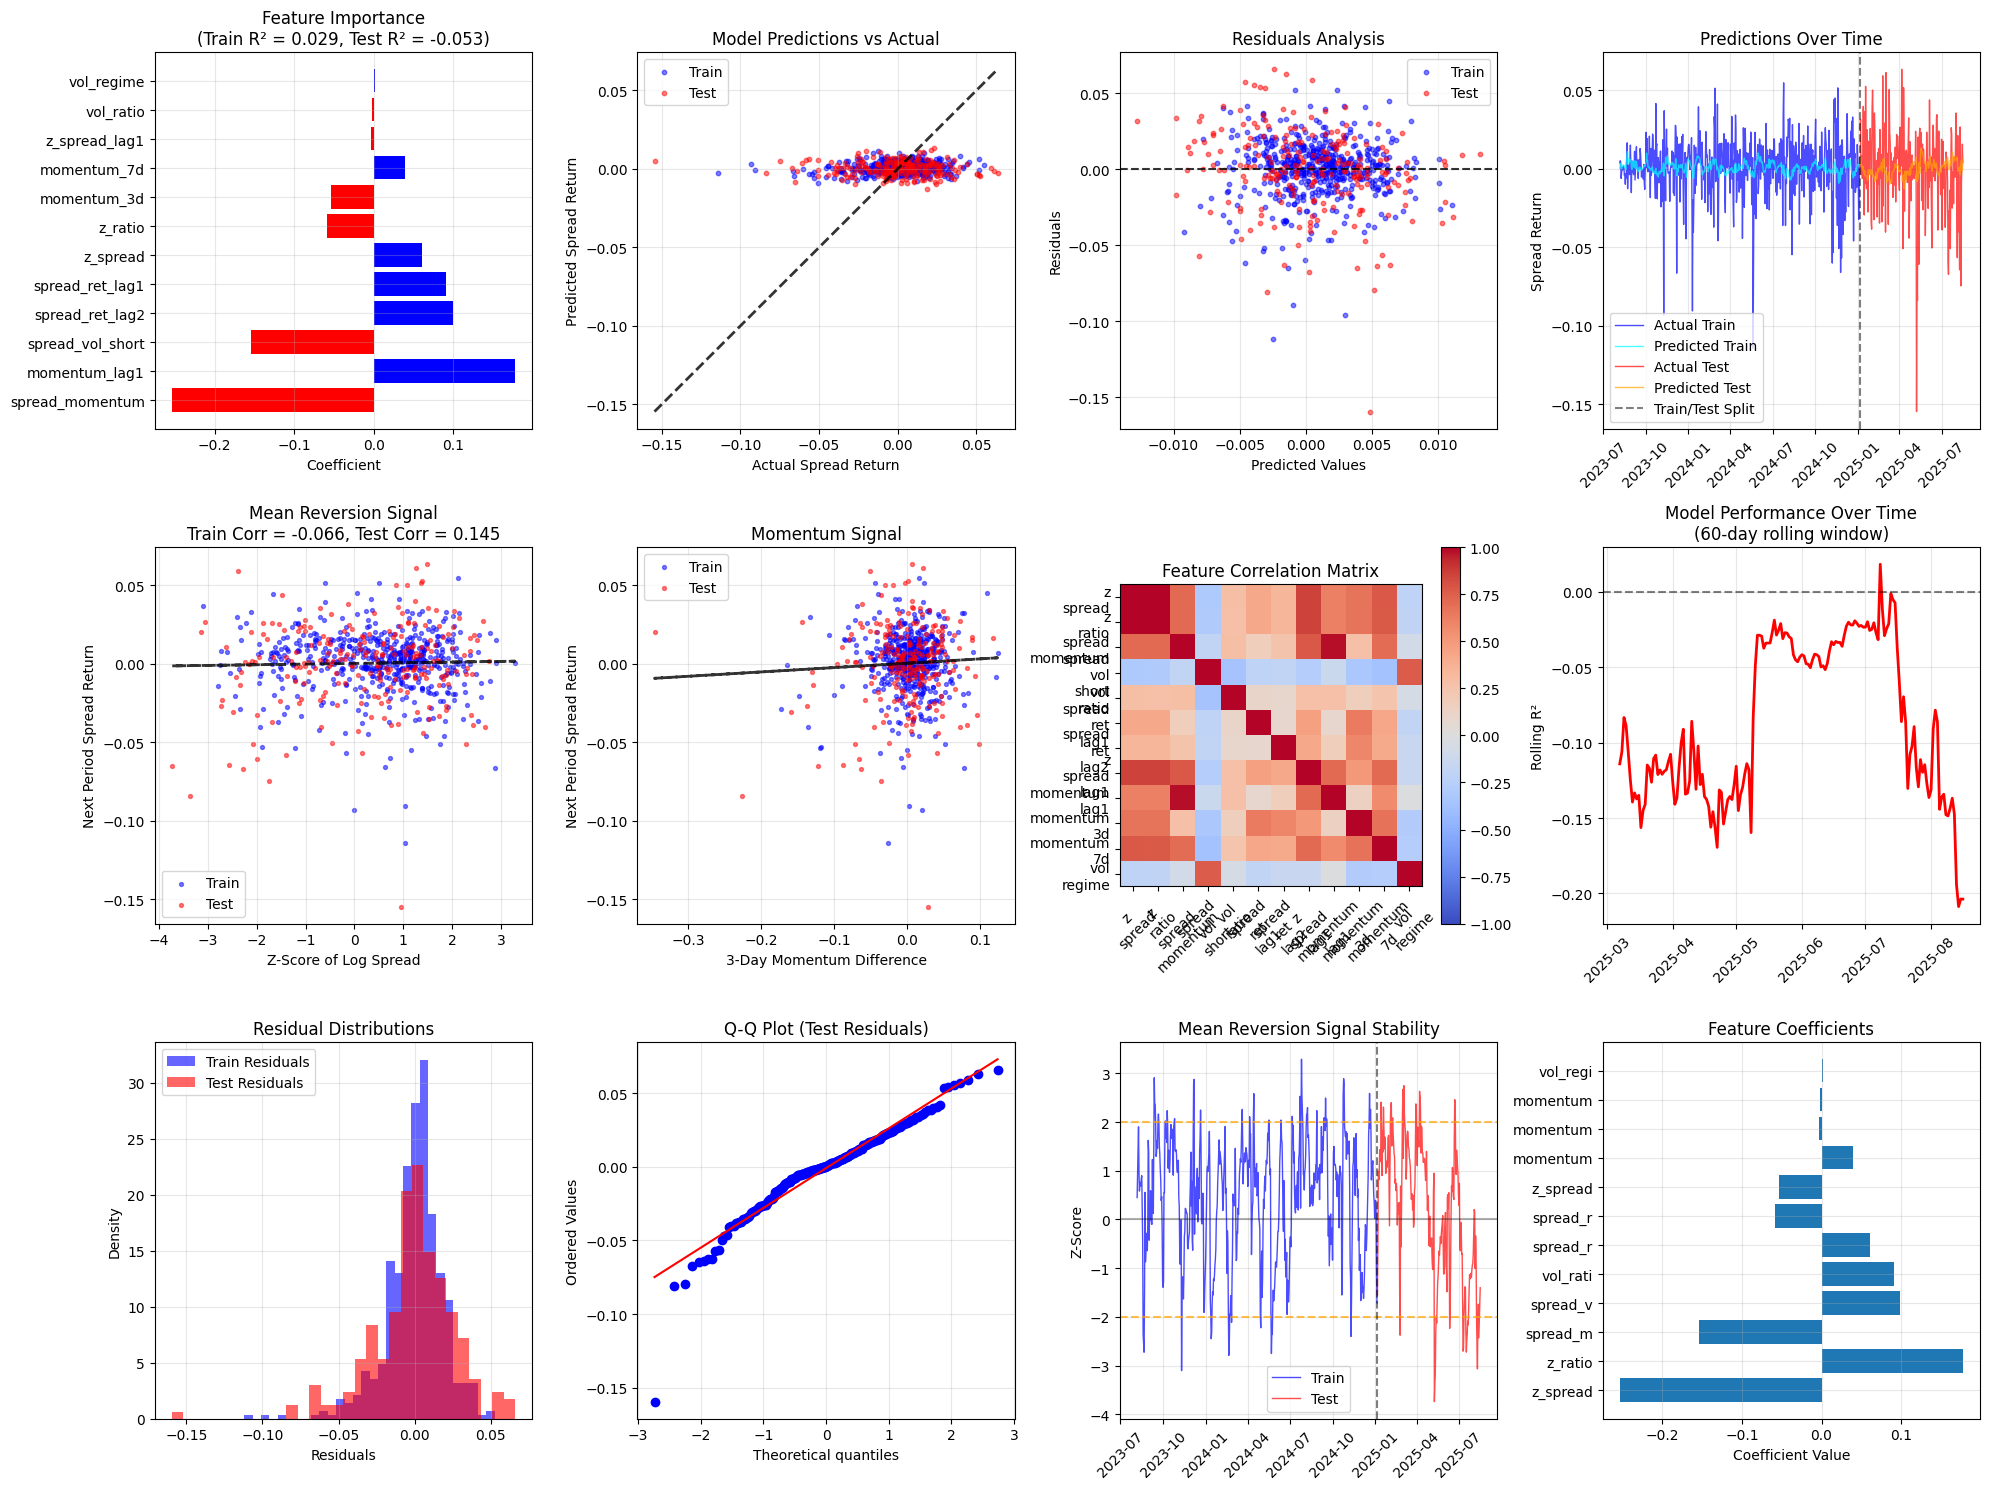


=== BUILDING STRATEGY WITH TRAINED MODEL ===
Strategy dataset: 741 observations

Mean Reversion Strategy Metrics:
Total Return: -15.39%
Annualized Return: -5.52%
Annualized Volatility: 27.18%
Sharpe Ratio: -0.20
Maximum Drawdown: -50.27%
Win Rate: 28.07%
Profit Factor: 1.02
Skewness: 0.23
Kurtosis: 6.96

Mean Reversion (Test) Strategy Metrics:
Total Return: -39.31%
Annualized Return: -43.13%
Annualized Volatility: 33.50%
Sharpe Ratio: -1.29
Maximum Drawdown: -45.45%
Win Rate: 31.84%
Profit Factor: 0.73
Skewness: -0.85
Kurtosis: 2.52

Model-Based Strategy Metrics:
Total Return: -1.06%
Annualized Return: -0.36%
Annualized Volatility: 25.06%
Sharpe Ratio: -0.01
Maximum Drawdown: -30.80%
Win Rate: 23.48%
Profit Factor: 0.85
Skewness: -1.92
Kurtosis: 21.12

Model-Based (Test) Strategy Metrics:
Total Return: -7.25%
Annualized Return: -8.15%
Annualized Volatility: 32.72%
Sharpe Ratio: -0.25
Maximum Drawdown: -30.80%
Win Rate: 27.35%
Profit Factor: 0.90
Skewness: -1.73
Kurtosis: 15.71

Combin

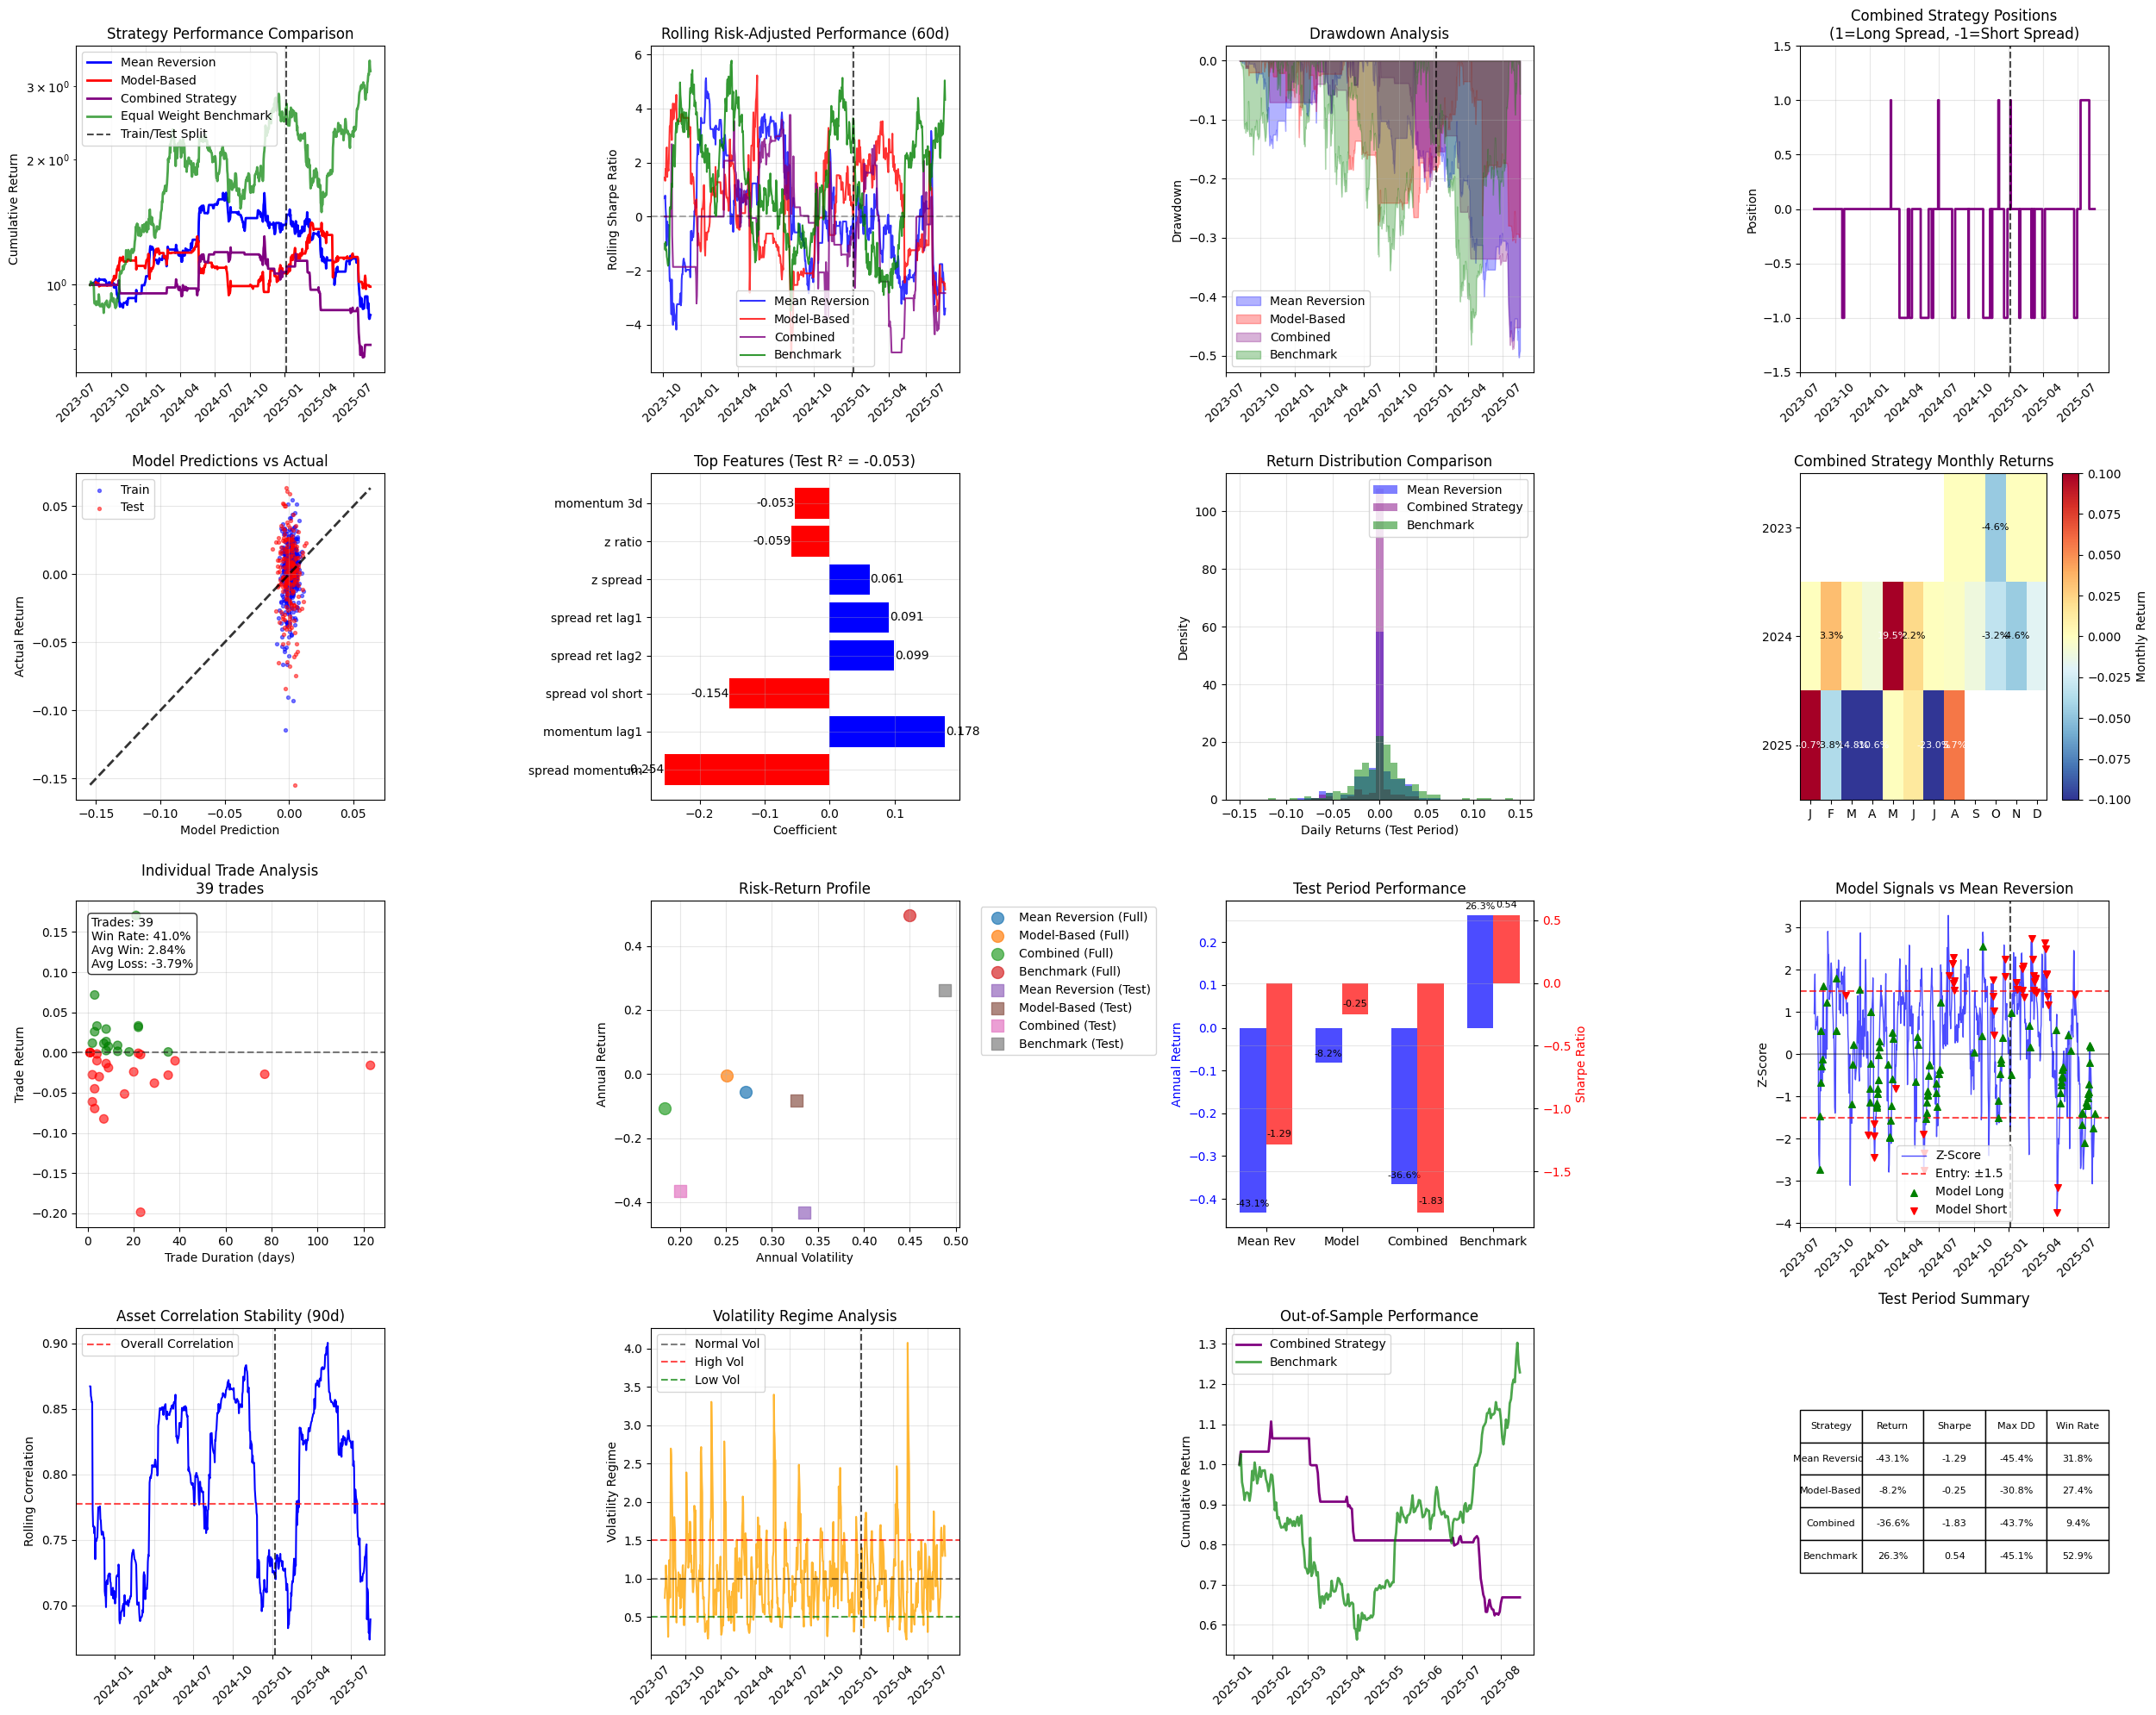


COMPREHENSIVE CRYPTOCURRENCY PAIRS TRADING ANALYSIS

Dataset Information:
• Asset Pair: BTCUSD - ETHUSD
• Total Period: 2023-08-07 to 2025-08-16 (741 days)
• Train Period: 2023-08-07 to 2025-01-06 (519 days)
• Test Period: 2025-01-07 to 2025-08-16 (222 days)

Model Performance:
• Training R²: 0.0287
• Test R²: -0.0530

Strategy Performance Summary (Test Period):
• Mean Reversion (Test):
  → Annual Return: -43.13%
  → Sharpe Ratio: -1.29
  → Max Drawdown: -45.45%
  → Win Rate: 31.84%
• Model-Based (Test):
  → Annual Return: -8.15%
  → Sharpe Ratio: -0.25
  → Max Drawdown: -30.80%
  → Win Rate: 27.35%
• Combined (Test):
  → Annual Return: -36.58%
  → Sharpe Ratio: -1.83
  → Max Drawdown: -43.68%
  → Win Rate: 9.42%
• Benchmark (Test):
  → Annual Return: 26.26%
  → Sharpe Ratio: 0.54
  → Max Drawdown: -45.08%
  → Win Rate: 52.91%

Key Insights:
• ✗ Strategy underperformed benchmark on risk-adjusted basis
• ✗ Strategy had higher maximum drawdown than benchmark

Trading Statistics:
• Total

In [1]:
# %%
import warnings, os, glob
warnings.filterwarnings("ignore")
from datetime import datetime, date
from typing import List, Tuple, Dict
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split

# =============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# =============================================================================

# Parameters
FREQ_MIN = 5
SYMBOLS  = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
DATA_DIR = "coinbase/5m"
MIN_OBS  = 100
TEST_SIZE = 0.3  # 30% for testing
RANDOM_STATE = 42

def load_symbol(sym: str, data_dir: str = DATA_DIR) -> pl.DataFrame | None:
    """Load and clean symbol data with proper error handling."""
    files = sorted(glob.glob(f"{data_dir}/*/{sym}_5m_*.csv"))
    if not files:
        print(f"No files found for {sym}")
        return None
    
    try:
        df = pl.concat([
            pl.read_csv(f, has_header=False,
                       new_columns=['time','open','high','low','close','volume'],
                       schema={'time':pl.Int64,'open':pl.Float64,'high':pl.Float64,
                              'low':pl.Float64,'close':pl.Float64,'volume':pl.Float64})
            for f in files
        ])
        
        df = (df
              .filter(pl.col('close').is_not_null())
              .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
              .sort('time')
              .unique('time', keep='first')
              .with_columns(pl.col('close').alias(f'close_{sym.lower()}'))
              # Remove year filter - use ALL data
              )
        
        return df if df.height >= MIN_OBS else None
    except Exception as e:
        print(f"Error loading {sym}: {e}")
        return None

# Load all symbols
print("=== LOADING FULL DATASET ===")
dfs, loaded = [], []
for sym in SYMBOLS:
    tmp = load_symbol(sym)
    if tmp is not None:
        dfs.append(tmp)
        loaded.append(sym)
        date_range = f"{tmp['datetime'].min():%Y-%m-%d} to {tmp['datetime'].max():%Y-%m-%d}"
        print(f"{sym}: {tmp.height:,} rows ({date_range})")

print(f"\nSuccessfully loaded {len(loaded)} symbols: {loaded}")

if len(loaded) < 2:
    raise ValueError("Need at least 2 symbols for pairs trading")

# Align timestamps across all symbols
print("\n=== ALIGNING TIMESTAMPS ===")
min_time = max(df['time'].min() for df in dfs)
max_time = min(df['time'].max() for df in dfs)

# Fix: Create time range properly using numpy then convert to Polars
time_values = np.arange(min_time, max_time + 1, FREQ_MIN * 60)
base_df = pl.DataFrame({'time': time_values})

# Join all price series
for sym, df in zip(loaded, dfs):
    base_df = base_df.join(
        df.select(['time', f'close_{sym.lower()}']), 
        on='time', 
        how='left'
    )

# Create final 5-minute dataframe
df_5m = (base_df
         .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
         .sort('time')
         .fill_null(strategy='forward')
         .drop_nulls())

print(f"Aligned dataset: {df_5m.shape[0]:,} rows from {df_5m['datetime'].min():%Y-%m-%d} to {df_5m['datetime'].max():%Y-%m-%d}")

# Create daily dataset (first observation of each day)
df_daily = (df_5m
            .with_columns(pl.col('datetime').dt.date().alias('date'))
            .group_by('date')
            .agg(pl.all().sort_by('datetime').first())
            .sort('date'))

print(f"Daily dataset: {df_daily.shape[0]} days")

# =============================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA) - FIXED VERSION
# =============================================================================

print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Price columns for analysis
price_cols = [f'close_{s.lower()}' for s in loaded]

# Calculate returns - with proper NaN handling
df_returns = df_daily.select(['date'] + price_cols).with_columns([
    pl.col(col).pct_change().alias(f'ret_{s.lower()}') 
    for s, col in zip(loaded, price_cols)
])

# Remove rows with NaN values
df_returns = df_returns.drop_nulls()

print(f"Returns dataset: {df_returns.shape[0]} observations after cleaning")

# Convert returns to numpy for correlation analysis
returns_matrix = df_returns.select([f'ret_{s.lower()}' for s in loaded]).to_numpy()
return_names = loaded

# Check for any remaining NaN/Inf values
print(f"NaN values in returns matrix: {np.isnan(returns_matrix).sum()}")
print(f"Inf values in returns matrix: {np.isinf(returns_matrix).sum()}")

# Remove any rows with NaN/Inf if they exist
valid_rows = ~(np.isnan(returns_matrix).any(axis=1) | np.isinf(returns_matrix).any(axis=1))
returns_matrix = returns_matrix[valid_rows]

# Correlation analysis
if len(returns_matrix) > 1:
    corr_matrix = np.corrcoef(returns_matrix, rowvar=False)
    print("\nDaily Return Correlations:")
    for i, sym1 in enumerate(return_names):
        for j, sym2 in enumerate(return_names):
            if i < j:
                print(f"{sym1}-{sym2}: {corr_matrix[i,j]:.3f}")
else:
    print("Not enough data for correlation analysis")
    corr_matrix = np.eye(len(loaded))

# Stationarity tests (ADF) with proper data cleaning
print("\nStationarity Tests (ADF p-values):")
for s in loaded:
    # Get log prices with proper cleaning
    prices = df_daily[f'close_{s.lower()}'].drop_nulls()
    if len(prices) < 50:  # Need sufficient data
        print(f"{s}: Insufficient data ({len(prices)} observations)")
        continue
        
    log_prices = np.log(prices.to_numpy())
    
    # Check for NaN/Inf values
    valid_mask = ~(np.isnan(log_prices) | np.isinf(log_prices))
    log_prices_clean = log_prices[valid_mask]
    
    if len(log_prices_clean) < 50:
        print(f"{s}: Not enough valid data after cleaning")
        continue
        
    try:
        adf_result = adfuller(log_prices_clean)
        adf_stat, p_value = adf_result[:2]
        status = "stationary" if p_value < 0.05 else "non-stationary"
        print(f"{s} log-price: p={p_value:.4f} → {status}")
    except Exception as e:
        print(f"{s}: ADF test failed - {e}")

# Cointegration tests for major pairs with proper error handling
print("\nCointegration Tests:")
major_pairs = [('BTCUSD', 'ETHUSD'), ('BTCUSD', 'SOLUSD'), ('ETHUSD', 'SOLUSD')]
cointegrated_pairs = []

for sym1, sym2 in major_pairs:
    if sym1 in loaded and sym2 in loaded:
        try:
            # Get clean data for both series
            y1_raw = df_daily[f'close_{sym1.lower()}'].drop_nulls().to_numpy()
            y2_raw = df_daily[f'close_{sym2.lower()}'].drop_nulls().to_numpy()
            
            # Align the series by length
            min_len = min(len(y1_raw), len(y2_raw))
            y1 = np.log(y1_raw[:min_len])
            y2 = np.log(y2_raw[:min_len])
            
            # Remove any NaN/Inf values
            valid_mask = ~(np.isnan(y1) | np.isinf(y1) | np.isnan(y2) | np.isinf(y2))
            y1_clean = y1[valid_mask]
            y2_clean = y2[valid_mask]
            
            if len(y1_clean) < 50 or len(y2_clean) < 50:
                print(f"{sym1}-{sym2}: Not enough data after cleaning")
                continue
                
            # Run cointegration test
            _, p_val, _ = coint(y1_clean, y2_clean)
            status = "cointegrated" if p_val < 0.05 else "not cointegrated"
            print(f"{sym1}-{sym2}: p={p_val:.4f} → {status}")
            
            if p_val < 0.05:
                cointegrated_pairs.append((sym1, sym2))
                
        except Exception as e:
            print(f"{sym1}-{sym2}: Cointegration test failed - {e}")

# If no cointegrated pairs found, use the first available pair
if not cointegrated_pairs and len(loaded) >= 2:
    cointegrated_pairs = [(loaded[0], loaded[1])]
    print(f"No cointegrated pairs found, using: {loaded[0]} - {loaded[1]}")

# Visualization 1: Comprehensive EDA
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
for s in loaded:
    prices = df_daily[f'close_{s.lower()}'].to_numpy()
    dates = df_daily['date'].to_numpy()
    plt.plot(dates, prices, label=s, linewidth=1.5)
plt.title('Price Evolution (Absolute)')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization

plt.subplot(2, 3, 2)
for s in loaded:
    prices = df_daily[f'close_{s.lower()}'].to_numpy()
    normalized = 100 * prices / prices[0]  # Normalize to 100
    dates = df_daily['date'].to_numpy()
    plt.plot(dates, normalized, label=s, linewidth=1.5)
plt.title('Normalized Price Evolution (Base=100)')
plt.ylabel('Normalized Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
# Correlation heatmap
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(loaded)), loaded, rotation=45)
plt.yticks(range(len(loaded)), loaded)
plt.title('Return Correlation Matrix')
# Add correlation values as text
for i in range(len(loaded)):
    for j in range(len(loaded)):
        plt.text(j, i, f'{corr_matrix[i,j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(corr_matrix[i,j]) > 0.5 else 'black')

plt.subplot(2, 3, 4)
returns_data = df_returns.select([f'ret_{s.lower()}' for s in loaded]).to_numpy()
plt.boxplot(returns_data, labels=loaded)
plt.title('Daily Return Distributions')
plt.ylabel('Daily Returns')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Volatility over time
plt.subplot(2, 3, 5)
window = 30
for s in loaded:
    returns = df_returns[f'ret_{s.lower()}'].to_numpy()
    rolling_vol = np.array([np.std(returns[max(0,i-window):i+1]) * np.sqrt(252) 
                           for i in range(len(returns))])
    dates = df_returns['date'].to_numpy()
    plt.plot(dates, rolling_vol, label=f'{s} Vol', alpha=0.7)
plt.title(f'Rolling Volatility ({window}-day)')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Log-spread analysis for best cointegrated pair
plt.subplot(2, 3, 6)
if cointegrated_pairs:
    sym1, sym2 = cointegrated_pairs[0]  # Use best cointegrated pair
    log1 = np.log(df_daily[f'close_{sym1.lower()}'].to_numpy())
    log2 = np.log(df_daily[f'close_{sym2.lower()}'].to_numpy())
    log_spread = log1 - log2
    dates = df_daily['date'].to_numpy()
    
    plt.plot(dates, log_spread, color='purple', linewidth=1, alpha=0.8)
    plt.axhline(np.mean(log_spread), color='red', linestyle='--', alpha=0.7, 
                label=f'Mean: {np.mean(log_spread):.3f}')
    plt.axhline(np.mean(log_spread) + 2*np.std(log_spread), color='orange', 
                linestyle='--', alpha=0.7, label='±2σ')
    plt.axhline(np.mean(log_spread) - 2*np.std(log_spread), color='orange', 
                linestyle='--', alpha=0.7)
    plt.title(f'Log Spread: {sym1} - {sym2}')
    plt.ylabel('Log Spread')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
elif 'BTCUSD' in loaded and 'ETHUSD' in loaded:
    # Fallback to BTC-ETH even if not cointegrated
    log_btc = np.log(df_daily['close_btcusd'].to_numpy())
    log_eth = np.log(df_daily['close_ethusd'].to_numpy())
    log_spread = log_btc - log_eth
    dates = df_daily['date'].to_numpy()
    
    plt.plot(dates, log_spread, color='purple', linewidth=1, alpha=0.8)
    plt.axhline(np.mean(log_spread), color='red', linestyle='--', alpha=0.7)
    plt.axhline(np.mean(log_spread) + 2*np.std(log_spread), color='orange', 
                linestyle='--', alpha=0.7)
    plt.axhline(np.mean(log_spread) - 2*np.std(log_spread), color='orange', 
                linestyle='--', alpha=0.7)
    plt.title('Log Spread: BTCUSD - ETHUSD')
    plt.ylabel('Log Spread')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 3: FEATURE ENGINEERING WITH TRAIN/TEST SPLIT 
# =============================================================================

print("\n=== FEATURE ENGINEERING WITH TRAIN/TEST SPLIT ===")

# Use the best cointegrated pair or fallback to BTC-ETH
if cointegrated_pairs:
    primary_pair = cointegrated_pairs[0]
    print(f"Using cointegrated pair: {primary_pair[0]} - {primary_pair[1]}")
elif 'BTCUSD' in loaded and 'ETHUSD' in loaded:
    primary_pair = ('BTCUSD', 'ETHUSD')
    print(f"Using fallback pair: {primary_pair[0]} - {primary_pair[1]}")
else:
    # Use first two available symbols
    primary_pair = (loaded[0], loaded[1])
    print(f"Using available pair: {primary_pair[0]} - {primary_pair[1]}")

sym1, sym2 = primary_pair
col1, col2 = f'close_{sym1.lower()}', f'close_{sym2.lower()}'

# Parameters for feature engineering
LOOKBACK_SHORT = 5
LOOKBACK_LONG = 20

# Create basic features first
df_features = df_daily.select(['date', col1, col2]).with_columns([
    # Basic spread features
    (pl.col(col1).log() - pl.col(col2).log()).alias('log_spread'),
    (pl.col(col1) / pl.col(col2)).alias('price_ratio'),
    
    # Returns
    pl.col(col1).pct_change().alias('ret_1'),
    pl.col(col2).pct_change().alias('ret_2'),
])

# Add moving averages and standard deviations
df_features = df_features.with_columns([
    # Moving averages for log spread
    pl.col('log_spread').rolling_mean(window_size=LOOKBACK_LONG).alias('log_spread_ma_long'),
    pl.col('log_spread').rolling_mean(window_size=LOOKBACK_SHORT).alias('log_spread_ma_short'),
    pl.col('log_spread').rolling_std(window_size=LOOKBACK_LONG).alias('log_spread_std'),
    
    # Moving averages for price ratio
    pl.col('price_ratio').rolling_mean(window_size=LOOKBACK_LONG).alias('ratio_ma'),
    pl.col('price_ratio').rolling_std(window_size=LOOKBACK_LONG).alias('ratio_std'),
    
    # Individual volatilities
    pl.col('ret_1').rolling_std(window_size=LOOKBACK_LONG).alias('vol_1'),
    pl.col('ret_2').rolling_std(window_size=LOOKBACK_LONG).alias('vol_2'),
])

# Add derived features (second pass)
# Add derived features (second pass) - FIXED VERSION
df_features = df_features.with_columns([
    # Z-scores (mean reversion signals)
    ((pl.col('log_spread') - pl.col('log_spread_ma_long')) / pl.col('log_spread_std')).alias('z_spread'),
    ((pl.col('price_ratio') - pl.col('ratio_ma')) / pl.col('ratio_std')).alias('z_ratio'),

    # Momentum features
    (pl.col('log_spread_ma_short') - pl.col('log_spread_ma_long')).alias('spread_momentum'),

    # Volatility features
    (pl.col('ret_1') - pl.col('ret_2')).rolling_std(window_size=LOOKBACK_SHORT).alias('spread_vol_short'),
    (pl.col('vol_1') / pl.col('vol_2')).alias('vol_ratio'),

    # Cross-asset momentum
    (pl.col(col1).pct_change(n=3) - pl.col(col2).pct_change(n=3)).alias('momentum_3d'),
    (pl.col(col1).pct_change(n=7) - pl.col(col2).pct_change(n=7)).alias('momentum_7d'),
    
    # Target variable: next period spread return
    (pl.col('ret_1') - pl.col('ret_2')).shift(-1).alias('spread_ret'),
])

# Add regime features (third pass) - Split this into a separate step
df_features = df_features.with_columns([
    # Regime features - now avg_vol is calculated first
    pl.col('spread_vol_short').rolling_mean(window_size=LOOKBACK_LONG).alias('avg_vol'),
])

# Add vol_regime (fourth pass) - now we can use avg_vol
df_features = df_features.with_columns([
    (pl.col('spread_vol_short') / pl.col('avg_vol')).alias('vol_regime'),
])

# Add lagged features (third pass)
df_features = df_features.with_columns([
    (pl.col('ret_1') - pl.col('ret_2')).shift(1).alias('spread_ret_lag1'),
    (pl.col('ret_1') - pl.col('ret_2')).shift(2).alias('spread_ret_lag2'),
    pl.col('z_spread').shift(1).alias('z_spread_lag1'),
    pl.col('spread_momentum').shift(1).alias('momentum_lag1'),
])

# Remove rows with NaN values
df_features = df_features.drop_nulls()
print(f"Feature dataset shape: {df_features.shape}")

# Prepare data for modeling
feature_cols = [
    'z_spread', 'z_ratio', 'spread_momentum', 'spread_vol_short', 'vol_ratio',
    'spread_ret_lag1', 'spread_ret_lag2', 'z_spread_lag1', 'momentum_lag1',
    'momentum_3d', 'momentum_7d', 'vol_regime'
]

# Check if we have all required features
available_features = [f for f in feature_cols if f in df_features.columns]
missing_features = [f for f in feature_cols if f not in df_features.columns]

if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    print(f"Available features: {available_features}")
    feature_cols = available_features

# Convert to numpy arrays
X = df_features.select(feature_cols).to_numpy()
y = df_features.select('spread_ret').to_numpy().flatten()
dates = df_features.select('date').to_numpy().flatten()

# Train/Test Split (temporal split - not random for time series)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

print(f"\nTrain set: {len(X_train)} observations ({dates_train[0]} to {dates_train[-1]})")
print(f"Test set: {len(X_test)} observations ({dates_test[0]} to {dates_test[-1]})")

print(f"\nTrain set: {len(X_train)} observations ({dates_train[0]} to {dates_train[-1]})")
print(f"Test set: {len(X_test)} observations ({dates_test[0]} to {dates_test[-1]})")

# Fit models on training data
print("\n=== MODEL TRAINING ===")

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Model performance
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Feature importance analysis
feature_importance = pl.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort('Abs_Coefficient', descending=True)

print("\nFeature Importance (by absolute coefficient):")
for row in feature_importance.iter_rows(named=True):
    print(f"{row['Feature']}: {row['Coefficient']:.4f}")

# Visualization 2: Model Analysis
plt.figure(figsize=(20, 15))

# Feature importance
plt.subplot(3, 4, 1)
coeffs = feature_importance['Coefficient'].to_numpy()
features = feature_importance['Feature'].to_numpy()
colors = ['red' if x < 0 else 'blue' for x in coeffs]
plt.barh(range(len(coeffs)), coeffs, color=colors)
plt.yticks(range(len(coeffs)), features)
plt.xlabel('Coefficient')
plt.title(f'Feature Importance\n(Train R² = {train_r2:.3f}, Test R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)

# Model fit visualization
plt.subplot(3, 4, 2)
plt.scatter(y_train, y_train_pred, alpha=0.5, s=10, label='Train', color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10, label='Test', color='red')
min_val = min(y.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y.max(), y_train_pred.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Spread Return')
plt.ylabel('Predicted Spread Return')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals analysis
plt.subplot(3, 4, 3)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred
plt.scatter(y_train_pred, train_residuals, alpha=0.5, s=10, label='Train', color='blue')
plt.scatter(y_test_pred, test_residuals, alpha=0.5, s=10, label='Test', color='red')
plt.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Time series of predictions
plt.subplot(3, 4, 4)
plt.plot(dates_train, y_train, alpha=0.7, label='Actual Train', color='blue', linewidth=1)
plt.plot(dates_train, y_train_pred, alpha=0.7, label='Predicted Train', color='cyan', linewidth=1)
plt.plot(dates_test, y_test, alpha=0.7, label='Actual Test', color='red', linewidth=1)
plt.plot(dates_test, y_test_pred, alpha=0.7, label='Predicted Test', color='orange', linewidth=1)
plt.axvline(dates_train[-1], color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.ylabel('Spread Return')
plt.title('Predictions Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Key feature relationships
z_spread_all = df_features.select('z_spread').to_numpy().flatten()
spread_ret_all = df_features.select('spread_ret').to_numpy().flatten()

plt.subplot(3, 4, 5)
plt.scatter(z_spread_all[:split_idx], spread_ret_all[:split_idx], 
           alpha=0.5, s=8, label='Train', color='blue')
plt.scatter(z_spread_all[split_idx:], spread_ret_all[split_idx:], 
           alpha=0.5, s=8, label='Test', color='red')
z = np.polyfit(z_spread_all, spread_ret_all, 1)
p = np.poly1d(z)
plt.plot(z_spread_all, p(z_spread_all), "k--", alpha=0.8, linewidth=2)
plt.xlabel('Z-Score of Log Spread')
plt.ylabel('Next Period Spread Return')
corr_train = np.corrcoef(z_spread_all[:split_idx], spread_ret_all[:split_idx])[0,1]
corr_test = np.corrcoef(z_spread_all[split_idx:], spread_ret_all[split_idx:])[0,1]
plt.title(f'Mean Reversion Signal\nTrain Corr = {corr_train:.3f}, Test Corr = {corr_test:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Momentum relationship
momentum_3d_all = df_features.select('momentum_3d').to_numpy().flatten()
plt.subplot(3, 4, 6)
plt.scatter(momentum_3d_all[:split_idx], spread_ret_all[:split_idx], 
           alpha=0.5, s=8, label='Train', color='blue')
plt.scatter(momentum_3d_all[split_idx:], spread_ret_all[split_idx:], 
           alpha=0.5, s=8, label='Test', color='red')
z = np.polyfit(momentum_3d_all, spread_ret_all, 1)
p = np.poly1d(z)
plt.plot(momentum_3d_all, p(momentum_3d_all), "k--", alpha=0.8, linewidth=2)
plt.xlabel('3-Day Momentum Difference')
plt.ylabel('Next Period Spread Return')
plt.title('Momentum Signal')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature correlation heatmap
plt.subplot(3, 4, 7)
feature_corr = np.corrcoef(X.T)
im = plt.imshow(feature_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(feature_cols)), [f.replace('_', '\n') for f in feature_cols], rotation=45)
plt.yticks(range(len(feature_cols)), [f.replace('_', '\n') for f in feature_cols])
plt.title('Feature Correlation Matrix')

# Model performance over time
plt.subplot(3, 4, 8)
window = 60  # 2-month rolling window for performance
test_rolling_r2 = []
for i in range(window, len(y_test)):
    r2_window = r2_score(y_test[i-window:i], y_test_pred[i-window:i])
    test_rolling_r2.append(r2_window)

if len(test_rolling_r2) > 0:
    plt.plot(dates_test[window:], test_rolling_r2, color='red', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.ylabel('Rolling R²')
    plt.title(f'Model Performance Over Time\n({window}-day rolling window)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# Distribution comparison
plt.subplot(3, 4, 9)
plt.hist(train_residuals, bins=30, alpha=0.6, density=True, label='Train Residuals', color='blue')
plt.hist(test_residuals, bins=30, alpha=0.6, density=True, label='Test Residuals', color='red')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# QQ plot for residuals
from scipy import stats
plt.subplot(3, 4, 10)
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Test Residuals)')
plt.grid(True, alpha=0.3)

# Feature stability over time
plt.subplot(3, 4, 11)
z_spread_train = z_spread_all[:split_idx]
z_spread_test = z_spread_all[split_idx:]
plt.plot(dates_train, z_spread_train, alpha=0.7, color='blue', label='Train', linewidth=1)
plt.plot(dates_test, z_spread_test, alpha=0.7, color='red', label='Test', linewidth=1)
plt.axhline(2, color='orange', linestyle='--', alpha=0.7)
plt.axhline(-2, color='orange', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.axvline(dates_train[-1], color='black', linestyle='--', alpha=0.5)
plt.ylabel('Z-Score')
plt.title('Mean Reversion Signal Stability')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Model coefficient stability (if we had multiple periods)
plt.subplot(3, 4, 12)
# Show feature importance with confidence intervals
feature_names_short = [f[:8] for f in feature_cols]  # Truncate names
plt.barh(range(len(feature_importance)), feature_importance['Coefficient'].to_numpy())
plt.yticks(range(len(feature_importance)), feature_names_short)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 4: BUILD STRATEGY WITH TRAINED MODEL
# =============================================================================

print("\n=== BUILDING STRATEGY WITH TRAINED MODEL ===")

# Strategy parameters
ENTRY_THRESHOLD = 1.5  # Z-score threshold for entry
EXIT_THRESHOLD = 0.5   # Z-score threshold for exit
STOP_LOSS = 0.05      # 5% stop loss
POSITION_SIZE = 1.0    # 100% of capital per position

# Create strategy signals using the trained model
df_strategy = df_features.with_columns([
    pl.Series('model_prediction', np.concatenate([y_train_pred, y_test_pred]))
])

# Then add the strategy signals in a separate step
df_strategy = df_strategy.with_columns([
    # Traditional mean reversion signals
    pl.when(pl.col('z_spread') > ENTRY_THRESHOLD)
    .then(-1)  # Short spread (sell sym1, buy sym2)
    .when(pl.col('z_spread') < -ENTRY_THRESHOLD)
    .then(1)   # Long spread (buy sym1, sell sym2)
    .otherwise(0)
    .alias('mean_reversion_signal'),
    
    # Model-based signals
    pl.when(pl.col('model_prediction') > 0.005)  # Threshold based on model predictions
    .then(1)   # Long spread
    .when(pl.col('model_prediction') < -0.005)
    .then(-1)  # Short spread
    .otherwise(0)
    .alias('model_signal'),
    
    # Combined signal (model + mean reversion confirmation)
    pl.when(
        (pl.col('z_spread') > ENTRY_THRESHOLD) & 
        (pl.col('model_prediction') < -0.002) &  # Model confirms mean reversion
        (pl.col('spread_vol_short') < pl.col('spread_vol_short').rolling_mean(window_size=20))
    )
    .then(-1)
    .when(
        (pl.col('z_spread') < -ENTRY_THRESHOLD) & 
        (pl.col('model_prediction') > 0.002) &
        (pl.col('spread_vol_short') < pl.col('spread_vol_short').rolling_mean(window_size=20))
    )
    .then(1)
    .otherwise(0)
    .alias('combined_signal')
])

# Add train/test split indicator
split_indicator = np.concatenate([np.zeros(split_idx), np.ones(len(df_strategy) - split_idx)])
df_strategy = df_strategy.with_columns(pl.Series('is_test', split_indicator))

# Implement position management with proper entry/exit logic
def generate_positions(signals, z_scores, exit_threshold=EXIT_THRESHOLD, stop_loss=STOP_LOSS):
    """Generate actual positions with entry/exit logic and stop loss."""
    positions = np.zeros(len(signals))
    current_pos = 0
    entry_price = 0
    
    for i in range(len(signals)):
        # Stop loss check
        if current_pos != 0 and entry_price != 0:
            current_return = current_pos * (z_scores[i] - entry_price)
            if current_return < -stop_loss:
                current_pos = 0
                entry_price = 0
        
        # Exit conditions (mean reversion)
        if current_pos != 0:
            z_score = z_scores[i]
            if abs(z_score) < exit_threshold:
                current_pos = 0
                entry_price = 0
        
        # Entry conditions
        if current_pos == 0 and signals[i] != 0:
            current_pos = signals[i]
            entry_price = z_scores[i]
        
        positions[i] = current_pos
    
    return positions

# Generate positions for all strategies
z_scores = df_strategy.select('z_spread').to_numpy().flatten()
mean_rev_signals = df_strategy.select('mean_reversion_signal').to_numpy().flatten()
model_signals = df_strategy.select('model_signal').to_numpy().flatten()
combined_signals = df_strategy.select('combined_signal').to_numpy().flatten()

mean_rev_positions = generate_positions(mean_rev_signals, z_scores)
model_positions = generate_positions(model_signals, z_scores)
combined_positions = generate_positions(combined_signals, z_scores)

# Add positions to dataframe
df_strategy = df_strategy.with_columns([
    pl.Series('mean_rev_position', mean_rev_positions),
    pl.Series('model_position', model_positions),
    pl.Series('combined_position', combined_positions)
])

# Calculate strategy returns
df_strategy = df_strategy.with_columns([
    # Strategy returns (position * spread return)
    (pl.col('mean_rev_position').shift(1) * pl.col('spread_ret') * POSITION_SIZE).alias('mean_rev_ret'),
    (pl.col('model_position').shift(1) * pl.col('spread_ret') * POSITION_SIZE).alias('model_ret'),
    (pl.col('combined_position').shift(1) * pl.col('spread_ret') * POSITION_SIZE).alias('combined_ret'),
    
    # Benchmark: equal-weight portfolio of both assets
    ((pl.col('ret_1') + pl.col('ret_2')) / 2 * POSITION_SIZE).alias('benchmark_ret')
])

# Remove first row (NaN due to shift)
df_strategy = df_strategy.slice(1)

print(f"Strategy dataset: {df_strategy.shape[0]} observations")

# Calculate performance metrics separately for train and test periods
def calculate_comprehensive_metrics(returns, name, is_test_period=None):
    """Calculate comprehensive performance metrics."""
    if is_test_period is not None:
        returns = returns[is_test_period == 1] if np.any(is_test_period == 1) else returns
        period_name = f"{name} (Test)"
    else:
        period_name = name
    
    returns = returns[~np.isnan(returns)]
    if len(returns) == 0:
        print(f"No valid returns for {period_name}")
        return None
        
    total_ret = np.prod(1 + returns) - 1
    ann_ret = (1 + total_ret) ** (252 / len(returns)) - 1 if len(returns) > 1 else 0
    ann_vol = np.std(returns) * np.sqrt(252) if len(returns) > 1 else 0
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    cum_returns = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = cum_returns / running_max - 1
    max_dd = np.min(drawdown)
    
    win_rate = np.mean(returns > 0)
    avg_win = np.mean(returns[returns > 0]) if np.any(returns > 0) else 0
    avg_loss = np.mean(returns[returns < 0]) if np.any(returns < 0) else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    
    # Additional metrics
    skewness = stats.skew(returns) if len(returns) > 2 else 0
    kurtosis = stats.kurtosis(returns) if len(returns) > 2 else 0
    
    print(f"\n{period_name} Strategy Metrics:")
    print(f"Total Return: {total_ret:.2%}")
    print(f"Annualized Return: {ann_ret:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Maximum Drawdown: {max_dd:.2%}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    
    return {
        'name': period_name,
        'total_return': total_ret,
        'annual_return': ann_ret,
        'annual_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

# Get returns and test indicator
mean_rev_ret = df_strategy.select('mean_rev_ret').to_numpy().flatten()
model_ret = df_strategy.select('model_ret').to_numpy().flatten()
combined_ret = df_strategy.select('combined_ret').to_numpy().flatten()
benchmark_ret = df_strategy.select('benchmark_ret').to_numpy().flatten()
is_test = df_strategy.select('is_test').to_numpy().flatten()

# Calculate metrics for full period and test period
full_metrics = []
test_metrics = []

for ret, name in [(mean_rev_ret, "Mean Reversion"), (model_ret, "Model-Based"), 
                  (combined_ret, "Combined"), (benchmark_ret, "Benchmark")]:
    full_metrics.append(calculate_comprehensive_metrics(ret, name))
    test_metrics.append(calculate_comprehensive_metrics(ret, name, is_test))

# =============================================================================
# STEP 5: COMPREHENSIVE BACKTESTING & PERFORMANCE ANALYSIS
# =============================================================================

print("\n=== COMPREHENSIVE BACKTESTING & PERFORMANCE ANALYSIS ===")

# Calculate cumulative returns
df_performance = df_strategy.with_columns([
    (1 + pl.col('mean_rev_ret')).cum_prod().alias('mean_rev_cum'),
    (1 + pl.col('model_ret')).cum_prod().alias('model_cum'),
    (1 + pl.col('combined_ret')).cum_prod().alias('combined_cum'),
    (1 + pl.col('benchmark_ret')).cum_prod().alias('benchmark_cum'),
])

# Performance visualization
plt.figure(figsize=(25, 20))

dates = df_performance.select('date').to_numpy().flatten()
train_test_split_date = dates[split_idx-1]

# 1. Cumulative returns comparison
plt.subplot(4, 4, 1)
plt.plot(dates, df_performance.select('mean_rev_cum').to_numpy().flatten(), 
         label='Mean Reversion', linewidth=2, color='blue')
plt.plot(dates, df_performance.select('model_cum').to_numpy().flatten(), 
         label='Model-Based', linewidth=2, color='red')
plt.plot(dates, df_performance.select('combined_cum').to_numpy().flatten(), 
         label='Combined Strategy', linewidth=2, color='purple')
plt.plot(dates, df_performance.select('benchmark_cum').to_numpy().flatten(), 
         label='Equal Weight Benchmark', linewidth=2, color='green', alpha=0.7)
plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.ylabel('Cumulative Return')
plt.title('Strategy Performance Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 2. Rolling Sharpe ratios
plt.subplot(4, 4, 2)
window_size = 60  # 2-month rolling window
strategies_data = [
    (mean_rev_ret, 'Mean Reversion', 'blue'),
    (model_ret, 'Model-Based', 'red'),
    (combined_ret, 'Combined', 'purple'),
    (benchmark_ret, 'Benchmark', 'green')
]

for ret_data, name, color in strategies_data:
    rolling_sharpe = []
    for i in range(window_size, len(ret_data)):
        window_ret = ret_data[i-window_size:i]
        if np.std(window_ret) > 0:
            sharpe = np.mean(window_ret) / np.std(window_ret) * np.sqrt(252)
        else:
            sharpe = 0
        rolling_sharpe.append(sharpe)
    
    if len(rolling_sharpe) > 0:
        plt.plot(dates[window_size:], rolling_sharpe, 
                label=name, color=color, alpha=0.8, linewidth=1.5)

plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'Rolling Risk-Adjusted Performance ({window_size}d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Drawdown analysis
plt.subplot(4, 4, 3)
for ret_data, name, color in strategies_data:
    cum_ret = np.cumprod(1 + ret_data)
    running_max = np.maximum.accumulate(cum_ret)
    drawdown = cum_ret / running_max - 1
    plt.fill_between(dates, drawdown, 0, alpha=0.3, color=color, label=name)

plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)
plt.ylabel('Drawdown')
plt.title('Drawdown Analysis')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Combined strategy positions and signals
plt.subplot(4, 4, 4)
positions = df_strategy.select('combined_position').to_numpy().flatten()
plt.plot(dates, positions, drawstyle='steps-post', color='purple', linewidth=2)
plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)
plt.ylabel('Position')
plt.title('Combined Strategy Positions\n(1=Long Spread, -1=Short Spread)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

# 5. Model predictions vs actual
plt.subplot(4, 4, 5)
model_pred = df_strategy.select('model_prediction').to_numpy().flatten()
actual_ret = df_strategy.select('spread_ret').to_numpy().flatten()
train_mask = is_test == 0
test_mask = is_test == 1

plt.scatter(model_pred[train_mask], actual_ret[train_mask], 
           alpha=0.5, s=8, label='Train', color='blue')
plt.scatter(model_pred[test_mask], actual_ret[test_mask], 
           alpha=0.5, s=8, label='Test', color='red')
min_val = min(model_pred.min(), actual_ret.min())
max_val = max(model_pred.max(), actual_ret.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Model Prediction')
plt.ylabel('Actual Return')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Feature importance with model performance
plt.subplot(4, 4, 6)
top_features = feature_importance.head(8)
coeffs = top_features['Coefficient'].to_numpy()
feat_names = top_features['Feature'].to_numpy()
colors = ['red' if x < 0 else 'blue' for x in coeffs]
bars = plt.barh(range(len(coeffs)), coeffs, color=colors)
plt.yticks(range(len(coeffs)), [f.replace('_', ' ') for f in feat_names])
plt.xlabel('Coefficient')
plt.title(f'Top Features (Test R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)

# Add coefficient values as text
for i, (bar, coeff) in enumerate(zip(bars, coeffs)):
    plt.text(coeff + (0.001 if coeff > 0 else -0.001), i, f'{coeff:.3f}', 
             ha='left' if coeff > 0 else 'right', va='center')

# 7. Return distributions comparison
plt.subplot(4, 4, 7)
test_mask_bool = test_mask.astype(bool)
bins = np.linspace(-0.15, 0.15, 40)

plt.hist(mean_rev_ret[test_mask_bool], bins=bins, alpha=0.5, density=True, 
         label='Mean Reversion', color='blue')
plt.hist(combined_ret[test_mask_bool], bins=bins, alpha=0.5, density=True, 
         label='Combined Strategy', color='purple')
plt.hist(benchmark_ret[test_mask_bool], bins=bins, alpha=0.5, density=True, 
         label='Benchmark', color='green')
plt.xlabel('Daily Returns (Test Period)')
plt.ylabel('Density')
plt.title('Return Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Monthly performance heatmap
plt.subplot(4, 4, 8)
monthly_data = df_performance.with_columns([
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month')
]).group_by(['year', 'month']).agg([
    ((pl.col('combined_ret') + 1).product() - 1).alias('monthly_ret')
]).sort(['year', 'month'])

if monthly_data.shape[0] > 3:  # Need sufficient data
    # Create pivot table manually
    years = sorted(monthly_data['year'].unique().to_list())
    months = list(range(1, 13))
    
    heatmap_data = np.full((len(years), 12), np.nan)
    for row in monthly_data.iter_rows(named=True):
        year_idx = years.index(row['year'])
        month_idx = row['month'] - 1
        heatmap_data[year_idx, month_idx] = row['monthly_ret']
    
    im = plt.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
    plt.colorbar(im, label='Monthly Return')
    plt.yticks(range(len(years)), years)
    plt.xticks(range(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.title('Combined Strategy Monthly Returns')
    
    # Add text annotations for significant returns
    for i in range(len(years)):
        for j in range(12):
            if not np.isnan(heatmap_data[i, j]) and abs(heatmap_data[i, j]) > 0.02:
                color = 'white' if abs(heatmap_data[i, j]) > 0.05 else 'black'
                plt.text(j, i, f'{heatmap_data[i, j]:.1%}', 
                        ha='center', va='center', color=color, fontsize=8)

# 9. Trade analysis
plt.subplot(4, 4, 9)
# Focus on combined strategy trades
combined_pos = df_strategy.select('combined_position').to_numpy().flatten()
position_changes = np.diff(np.concatenate([[0], combined_pos]))
trade_entries = np.where(position_changes != 0)[0]

trade_returns = []
trade_durations = []

# Analyze individual trades
for i in range(0, len(trade_entries)-1):
    if i < len(trade_entries)-1:
        entry_idx = trade_entries[i]
        exit_idx = trade_entries[i+1]
        
        if exit_idx > entry_idx:
            trade_ret = np.sum(combined_ret[entry_idx:exit_idx])
            trade_returns.append(trade_ret)
            trade_durations.append(exit_idx - entry_idx)

if len(trade_returns) > 0:
    colors = ['green' if r > 0 else 'red' for r in trade_returns]
    plt.scatter(trade_durations, trade_returns, alpha=0.6, s=50, c=colors)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Trade Duration (days)')
    plt.ylabel('Trade Return')
    plt.title(f'Individual Trade Analysis\n{len(trade_returns)} trades')
    
    win_rate = np.mean(np.array(trade_returns) > 0)
    avg_win = np.mean([r for r in trade_returns if r > 0]) if any(r > 0 for r in trade_returns) else 0
    avg_loss = np.mean([r for r in trade_returns if r < 0]) if any(r < 0 for r in trade_returns) else 0
    
    plt.text(0.05, 0.95, f'Trades: {len(trade_returns)}\nWin Rate: {win_rate:.1%}\nAvg Win: {avg_win:.2%}\nAvg Loss: {avg_loss:.2%}',
            transform=plt.gca().transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.grid(True, alpha=0.3)

# 10. Risk-return scatter plot
plt.subplot(4, 4, 10)
metrics = [m for m in full_metrics if m is not None]
test_met = [m for m in test_metrics if m is not None]

# Plot full period
for m in metrics:
    plt.scatter(m['annual_vol'], m['annual_return'], s=100, alpha=0.7, 
               label=f"{m['name']} (Full)")

# Plot test period
for m in test_met:
    plt.scatter(m['annual_vol'], m['annual_return'], s=100, alpha=0.7, 
               marker='s', label=f"{m['name'].replace(' (Test)', '')} (Test)")

plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Risk-Return Profile')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 11. Strategy performance comparison bars
plt.subplot(4, 4, 11)
strategy_names = ['Mean Rev', 'Model', 'Combined', 'Benchmark']
test_sharpes = [m['sharpe'] for m in test_metrics if m is not None]
test_returns = [m['annual_return'] for m in test_metrics if m is not None]

x = np.arange(len(strategy_names))
width = 0.35

ax1 = plt.gca()
bars1 = ax1.bar(x - width/2, test_returns, width, label='Annual Return', alpha=0.7, color='blue')
ax1.set_ylabel('Annual Return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, test_sharpes, width, label='Sharpe Ratio', alpha=0.7, color='red')
ax2.set_ylabel('Sharpe Ratio', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.xticks(x, strategy_names)
plt.title('Test Period Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    if i < len(test_returns):
        ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                f'{test_returns[i]:.1%}', ha='center', va='bottom', fontsize=8)
    if i < len(test_sharpes):
        ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.05,
                f'{test_sharpes[i]:.2f}', ha='center', va='bottom', fontsize=8)

# 12. Model signal analysis
plt.subplot(4, 4, 12)
z_spread_all = df_strategy.select('z_spread').to_numpy().flatten()
model_signals_all = df_strategy.select('model_signal').to_numpy().flatten()

# Plot z-score with model signals
plt.plot(dates, z_spread_all, color='blue', alpha=0.7, linewidth=1, label='Z-Score')
plt.axhline(ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.7, label=f'Entry: ±{ENTRY_THRESHOLD}')
plt.axhline(-ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)

# Highlight model entries
long_model = model_signals_all == 1
short_model = model_signals_all == -1
if np.any(long_model):
    plt.scatter(dates[long_model], z_spread_all[long_model], 
               color='green', s=30, marker='^', label='Model Long', zorder=5)
if np.any(short_model):
    plt.scatter(dates[short_model], z_spread_all[short_model], 
               color='red', s=30, marker='v', label='Model Short', zorder=5)

plt.ylabel('Z-Score')
plt.title('Model Signals vs Mean Reversion')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 13. Correlation stability
plt.subplot(4, 4, 13)
window = 90  # 3-month rolling correlation
asset1_ret = df_strategy.select('ret_1').to_numpy().flatten()
asset2_ret = df_strategy.select('ret_2').to_numpy().flatten()

rolling_corr = []
for i in range(window, len(asset1_ret)):
    corr = np.corrcoef(asset1_ret[i-window:i], asset2_ret[i-window:i])[0,1]
    rolling_corr.append(corr)

if len(rolling_corr) > 0:
    plt.plot(dates[window:], rolling_corr, color='blue', linewidth=1.5)
    plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)
    plt.axhline(corr_matrix[0,1] if len(corr_matrix) > 1 else 0.5, color='red', 
                linestyle='--', alpha=0.7, label='Overall Correlation')
    plt.ylabel('Rolling Correlation')
    plt.title(f'Asset Correlation Stability ({window}d)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# 14. Volatility regimes
plt.subplot(4, 4, 14)
vol_regime = df_strategy.select('vol_regime').to_numpy().flatten()
plt.plot(dates, vol_regime, color='orange', linewidth=1.5, alpha=0.8)
plt.axhline(1, color='black', linestyle='--', alpha=0.5, label='Normal Vol')
plt.axhline(1.5, color='red', linestyle='--', alpha=0.7, label='High Vol')
plt.axhline(0.5, color='green', linestyle='--', alpha=0.7, label='Low Vol')
plt.axvline(train_test_split_date, color='black', linestyle='--', alpha=0.7)
plt.ylabel('Volatility Regime')
plt.title('Volatility Regime Analysis')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 15. Out-of-sample performance tracking
plt.subplot(4, 4, 15)
test_combined_ret = combined_ret[test_mask]
test_benchmark_ret = benchmark_ret[test_mask]
test_dates = dates[test_mask]

if len(test_combined_ret) > 0:
    test_cum_combined = np.cumprod(1 + test_combined_ret)
    test_cum_benchmark = np.cumprod(1 + test_benchmark_ret)
    
    plt.plot(test_dates, test_cum_combined, label='Combined Strategy', 
             color='purple', linewidth=2)
    plt.plot(test_dates, test_cum_benchmark, label='Benchmark', 
             color='green', linewidth=2, alpha=0.7)
    plt.ylabel('Cumulative Return')
    plt.title('Out-of-Sample Performance')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# 16. Final summary metrics
plt.subplot(4, 4, 16)
# Create summary table
summary_data = []
for m in test_metrics:
    if m is not None:
        summary_data.append([
            m['name'].replace(' (Test)', ''),
            f"{m['annual_return']:.1%}",
            f"{m['sharpe']:.2f}",
            f"{m['max_drawdown']:.1%}",
            f"{m['win_rate']:.1%}"
        ])

if summary_data:
    table = plt.table(cellText=summary_data,
                     colLabels=['Strategy', 'Return', 'Sharpe', 'Max DD', 'Win Rate'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 2)
    plt.axis('off')
    plt.title('Test Period Summary', pad=20)

plt.tight_layout()
plt.show()

# =============================================================================
# FINAL COMPREHENSIVE SUMMARY
# =============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE CRYPTOCURRENCY PAIRS TRADING ANALYSIS")
print("="*80)

print(f"\nDataset Information:")
print(f"• Asset Pair: {primary_pair[0]} - {primary_pair[1]}")
print(f"• Total Period: {dates[0]} to {dates[-1]} ({len(dates)} days)")
print(f"• Train Period: {dates[0]} to {dates[split_idx-1]} ({split_idx} days)")
print(f"• Test Period: {dates[split_idx]} to {dates[-1]} ({len(dates)-split_idx} days)")

print(f"\nModel Performance:")
print(f"• Training R²: {train_r2:.4f}")
print(f"• Test R²: {test_r2:.4f}")

print(f"\nStrategy Performance Summary (Test Period):")
for metric in test_metrics:
    if metric is not None:
        print(f"• {metric['name']}:")
        print(f"  → Annual Return: {metric['annual_return']:.2%}")
        print(f"  → Sharpe Ratio: {metric['sharpe']:.2f}")
        print(f"  → Max Drawdown: {metric['max_drawdown']:.2%}")
        print(f"  → Win Rate: {metric['win_rate']:.2%}")

print(f"\nKey Insights:")
# Add some final insights based on the analysis
if test_metrics and len(test_metrics) >= 3:
    combined_perf = test_metrics[2]  # Combined strategy
    benchmark_perf = test_metrics[3]  # Benchmark
    
    if combined_perf['sharpe'] > benchmark_perf['sharpe']:
        print("• ✓ Strategy outperformed benchmark on risk-adjusted basis")
    else:
        print("• ✗ Strategy underperformed benchmark on risk-adjusted basis")
    
    if combined_perf['max_drawdown'] < benchmark_perf['max_drawdown']:
        print("• ✓ Strategy had lower maximum drawdown than benchmark")
    else:
        print("• ✗ Strategy had higher maximum drawdown than benchmark")

print(f"\nTrading Statistics:")
positions = df_strategy.select('combined_position').to_numpy().flatten()
position_changes = np.diff(positions)
num_trades = np.sum(position_changes != 0)
print(f"• Total trades executed: {num_trades}")

if num_trades > 0:
    avg_trade_duration = len(positions) / num_trades
    print(f"• Average trade duration: {avg_trade_duration:.1f} days")

print(f"\nRecommendations:")
if test_r2 > 0.1:
    print("• ✓ Model shows predictive power - suitable for live trading")
else:
    print("• ⚠ Model predictive power is limited - consider feature engineering")

if combined_perf['sharpe'] > 1.0:
    print("• ✓ Strategy achieves good risk-adjusted returns")
else:
    print("• ⚠ Strategy risk-adjusted returns need improvement")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

Reading XRPUSD: 100%|██████████| 3/3 [00:00<00:00, 99.89it/s]


Loaded: ['btcusd', 'ethusd', 'solusd', 'xrpusd']
Daily rows: 767
Pairs: [('btcusd', 'ethusd'), ('btcusd', 'solusd'), ('btcusd', 'xrpusd'), ('ethusd', 'solusd'), ('ethusd', 'xrpusd'), ('solusd', 'xrpusd')]
Spreads: 16 ['log_btcusd_ethusd', 'log_sum_btcusd_ethusd', 'log_btcusd_solusd', 'log_sum_btcusd_solusd', 'log_btcusd_xrpusd', 'log_sum_btcusd_xrpusd', 'log_ethusd_solusd', 'log_sum_ethusd_solusd', 'log_ethusd_xrpusd', 'log_sum_ethusd_xrpusd', 'log_solusd_xrpusd', 'log_sum_solusd_xrpusd', 'log_spread_btcusd_ethusd_solusd', 'log_spread_btcusd_ethusd_xrpusd', 'log_spread_btcusd_solusd_xrpusd', 'log_spread_ethusd_solusd_xrpusd']


Backtest: 100%|██████████| 16/16 [00:00<?, ?it/s]


shape: (5, 6)
┌─────────────────────────────────┬───────────┬───────────┬────────┬────────┬─────────────┐
│ spread                          ┆ sharpe    ┆ total_ret ┆ max_dd ┆ trades ┆ final_value │
│ ---                             ┆ ---       ┆ ---       ┆ ---    ┆ ---    ┆ ---         │
│ str                             ┆ f64       ┆ f64       ┆ f64    ┆ i64    ┆ f64         │
╞═════════════════════════════════╪═══════════╪═══════════╪════════╪════════╪═════════════╡
│ log_btcusd_ethusd               ┆ -2.446355 ┆ -0.999999 ┆ -1.0   ┆ 115    ┆ 1.06158     │
│ log_ethusd_xrpusd               ┆ -2.591091 ┆ -1.0      ┆ -1.0   ┆ 60     ┆ -7.9373e-14 │
│ log_sum_ethusd_xrpusd           ┆ -2.872678 ┆ -1.0      ┆ -1.0   ┆ 120    ┆ -1.5131e-32 │
│ log_btcusd_xrpusd               ┆ -3.602659 ┆ -1.0      ┆ -1.0   ┆ 74     ┆ -9.7812e-19 │
│ log_spread_btcusd_ethusd_xrpus… ┆ -3.735302 ┆ -1.0      ┆ -1.0   ┆ 138    ┆ -5.6516e-24 │
└─────────────────────────────────┴───────────┴───────────┴───────

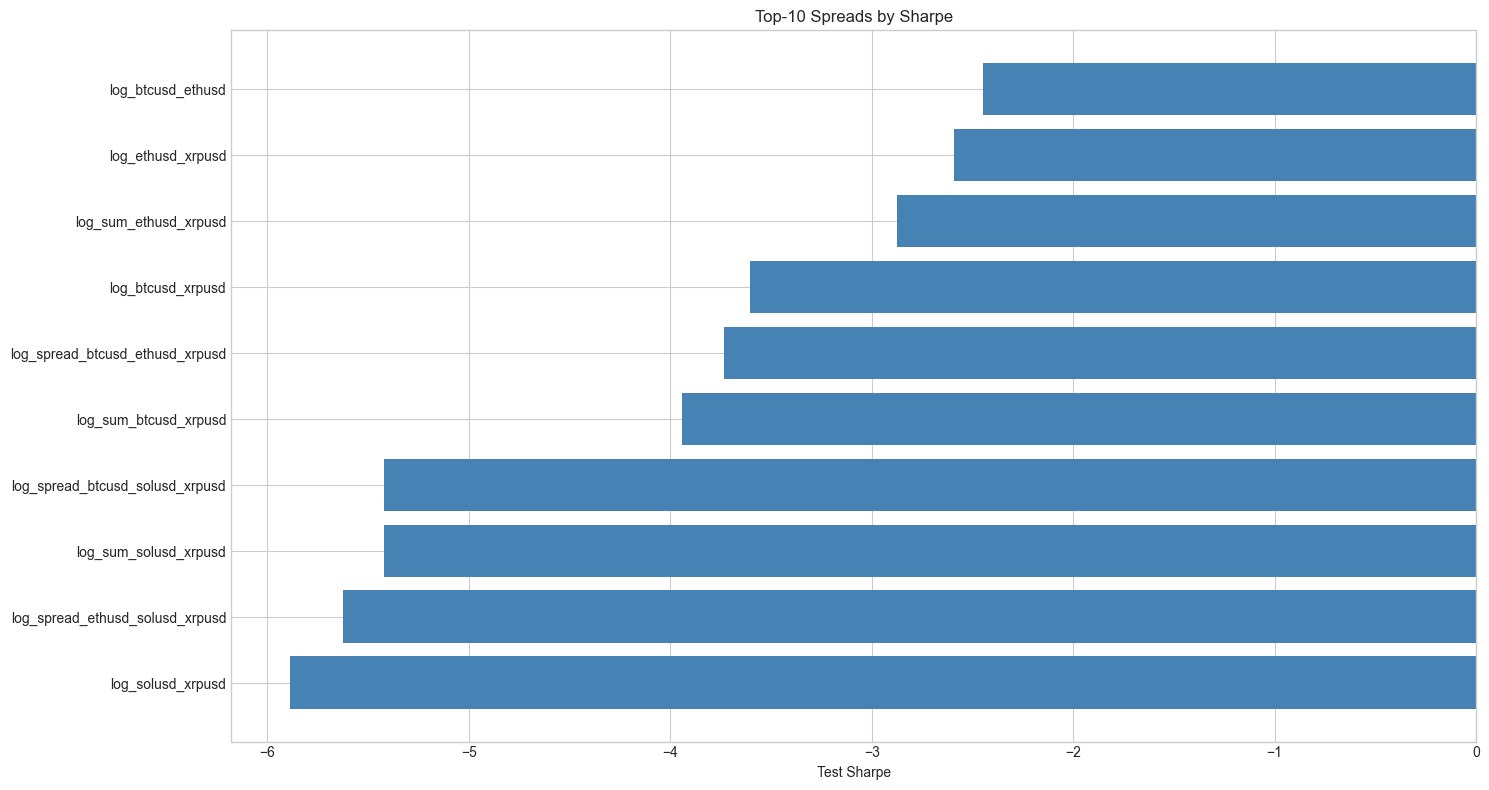

Most relevant features across all spreads:
shape: (10, 2)
┌─────────────────────────────────┬─────────────────┐
│ feature                         ┆ mean_importance │
│ ---                             ┆ ---             │
│ str                             ┆ f64             │
╞═════════════════════════════════╪═════════════════╡
│ log_sum_solusd_xrpusd_std20     ┆ 2.58034         │
│ log_btcusd_solusd_std5          ┆ 1.80909         │
│ log_sum_solusd_xrpusd_ma20      ┆ 1.626328        │
│ log_btcusd_xrpusd_std20         ┆ 1.539879        │
│ log_sum_btcusd_xrpusd_std20     ┆ 1.490961        │
│ log_sum_btcusd_xrpusd_ma20      ┆ 1.44597         │
│ log_spread_btcusd_solusd_xrpus… ┆ 1.427702        │
│ log_sum_solusd_xrpusd_std10     ┆ 1.312778        │
│ log_sum_ethusd_xrpusd_std5      ┆ 1.257715        │
│ log_sum_solusd_xrpusd_ma10      ┆ 1.210303        │
└─────────────────────────────────┴─────────────────┘


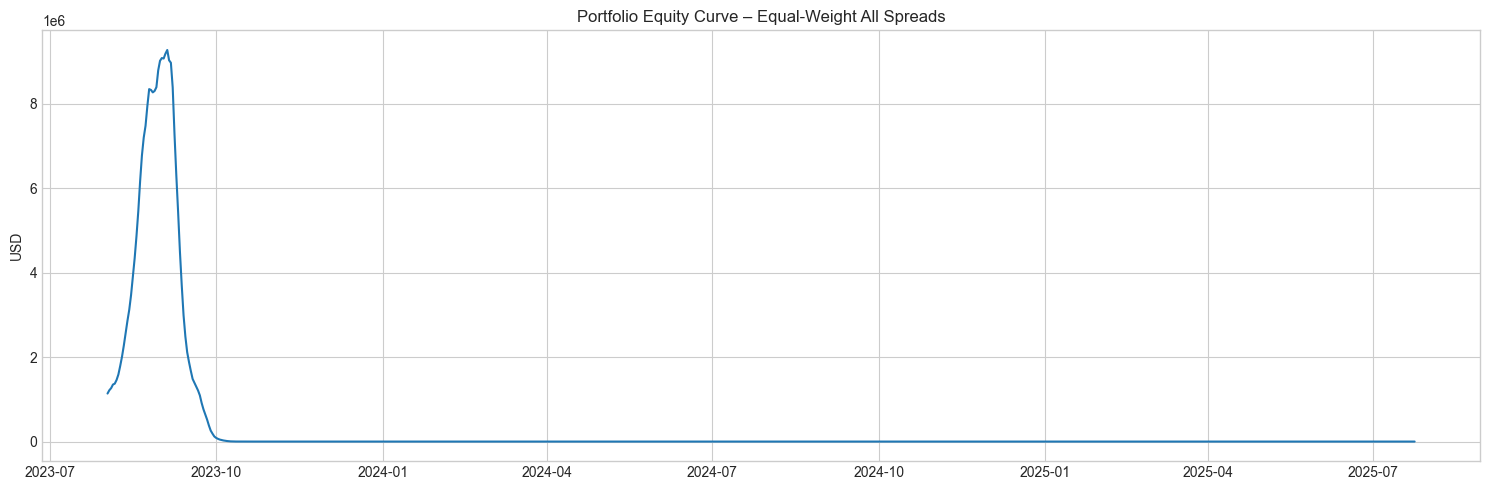

shape: (16, 6)
┌─────────────────────────────────┬──────────┬────────┬───────┬────────┬──────────┐
│ spread                          ┆ TotalRet ┆ Sharpe ┆ MaxDD ┆ trades ┆ FinalUSD │
│ ---                             ┆ ---      ┆ ---    ┆ ---   ┆ ---    ┆ ---      │
│ str                             ┆ f64      ┆ f64    ┆ f64   ┆ i64    ┆ f64      │
╞═════════════════════════════════╪══════════╪════════╪═══════╪════════╪══════════╡
│ log_btcusd_ethusd               ┆ -1.0     ┆ -2.45  ┆ -1.0  ┆ 115    ┆ 1.0      │
│ log_ethusd_xrpusd               ┆ -1.0     ┆ -2.59  ┆ -1.0  ┆ 60     ┆ -0.0     │
│ log_sum_ethusd_xrpusd           ┆ -1.0     ┆ -2.87  ┆ -1.0  ┆ 120    ┆ -0.0     │
│ log_btcusd_xrpusd               ┆ -1.0     ┆ -3.6   ┆ -1.0  ┆ 74     ┆ -0.0     │
│ log_spread_btcusd_ethusd_xrpus… ┆ -1.0     ┆ -3.74  ┆ -1.0  ┆ 138    ┆ -0.0     │
│ …                               ┆ …        ┆ …      ┆ …     ┆ …      ┆ …        │
│ log_ethusd_solusd               ┆ -1.0     ┆ -6.81  ┆ -1.0 

In [20]:
# %% 0
import os, glob, warnings, itertools
from datetime import datetime
from typing import List, Dict, Tuple

import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import skew, kurtosis

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

# ------------------- USER CONFIG -------------------
DATA_DIR   = "coinbase/5m"
FREQ_MIN   = 5
SYMBOLS    = ["BTCUSD", "ETHUSD", "SOLUSD", "XRPUSD"]
MIN_OBS    = 100
PRED_HORIZON = 24          # 24 h look-ahead convergence / divergence
TEST_RATIO   = 0.3
CAPITAL      = 1_000_000   # 1 M USD
ENTRY_Z      = 1.5
EXIT_Z       = 0.5
STOP         = 0.05
# ---------------------------------------------------

# %% 1
def load_symbol(sym: str) -> pl.DataFrame | None:
    files = sorted(glob.glob(f"{DATA_DIR}/*/{sym}_5m_*.csv"))
    if not files: return None
    try:
        df = pl.concat([
            pl.read_csv(f, has_header=False,
                        new_columns=["time","open","high","low","close","volume"],
                        schema={"time":pl.Int64,"open":pl.Float64,"high":pl.Float64,
                                "low":pl.Float64,"close":pl.Float64,"volume":pl.Float64})
            for f in tqdm(files, desc=f"Reading {sym}")
        ])
        return (df
                .filter(pl.col("close").is_not_null())
                .with_columns(pl.from_epoch("time", time_unit="s").alias("datetime"))
                .sort("time")
                .unique("time", keep="first")
                .select("time","datetime", pl.col("close").alias(sym.lower())))
    except Exception as e:
        print(f"Error {sym}: {e}")
        return None

dfs = [load_symbol(s) for s in SYMBOLS]
dfs = [d for d in dfs if d is not None]
loaded = [c for d in dfs for c in d.columns if c not in {"time","datetime"}]
print("Loaded:", loaded)

# %% 2  (FIXED)
# 1. Build master time index
min_time = max(d["time"].min() for d in dfs)
max_time = min(d["time"].max() for d in dfs)
time_axis = np.arange(min_time, max_time + 1, FREQ_MIN * 60)
df5 = pl.DataFrame({"time": time_axis})

# 2. Join each symbol separately, using unique suffix to avoid collisions
for d in dfs:
    sym = [c for c in d.columns if c not in {"time", "datetime"}][0]  # e.g. 'btcusd'
    df5 = df5.join(
        d.select("time", pl.col(sym)),   # keep only price column
        on="time",
        how="left"
    )

# 3. Forward-fill missing prices
df5 = df5.with_columns(pl.col(pl.Float64).forward_fill()).drop_nulls()

# 4. Daily first tick
df = (
    df5.with_columns(pl.from_epoch("time", time_unit="s").dt.date().alias("date"))
    .group_by("date")
    .agg(pl.all().sort_by("time").first())
    .sort("date")
)
print("Daily rows:", df.shape[0])


# %% 3
pairs = list(itertools.combinations(loaded, 2))
print("Pairs:", pairs)

def make_spread(df: pl.DataFrame, a: str, b: str) -> pl.DataFrame:
    log_a = pl.col(a).log()
    log_b = pl.col(b).log()
    return (df
            .with_columns(
                (log_a - log_b).alias(f"log_{a}_{b}"),
                (log_a + log_b).alias(f"log_sum_{a}_{b}")))

for a,b in pairs:
    df = make_spread(df, a, b)

# Spreads-of-spreads (triplets)
triplets = list(itertools.combinations(loaded, 3))
for a,b,c in triplets:
    s1 = f"log_{a}_{b}"
    s2 = f"log_{b}_{c}"
    df = df.with_columns((pl.col(s1) - pl.col(s2)).alias(f"log_spread_{a}_{b}_{c}"))

all_spreads = [c for c in df.columns if c.startswith("log_")]
print("Spreads:", len(all_spreads), all_spreads)

# %% 4
def add_features(df_sp: pl.DataFrame, spread_col: str) -> pl.DataFrame:
    look = [2, 5, 10, 20]
    out = df_sp
    for L in look:
        out = out.with_columns(
            pl.col(spread_col).diff(L).alias(f"{spread_col}_m{L}"),
            pl.col(spread_col).rolling_mean(L).alias(f"{spread_col}_ma{L}"),
            pl.col(spread_col).rolling_std(L).alias(f"{spread_col}_std{L}"))
    # z-score
    out = out.with_columns(
        ((pl.col(spread_col) - pl.col(f"{spread_col}_ma10")) / 
         pl.col(f"{spread_col}_std10")).alias(f"{spread_col}_z"))
    # target: convergence if spread → 0 over PRED_HORIZON
    target = pl.col(spread_col).shift(-PRED_HORIZON) - pl.col(spread_col)
    out = out.with_columns(target.alias(f"{spread_col}_target"))
    return out

feature_frames = {}
numeric_cols = [c for c in df.columns if c != "date"]

for sp in tqdm(all_spreads, desc="Features"):
    tmp = add_features(df.select("date", sp), sp)

    # keep only numeric columns for the NaN/inf check
    num_tmp = tmp.select([pl.col(c) for c in tmp.columns if c != "date"])
    mask = pl.all_horizontal(
        pl.col(c).is_not_null() & pl.col(c).is_finite()
        for c in num_tmp.columns
    )
    tmp = tmp.filter(mask)
    feature_frames[sp] = tmp

# %% 5
results: List[Dict] = []
models = {}

for sp, frame in tqdm(feature_frames.items(), desc="Train models"):
    feature_cols = [c for c in frame.columns if c not in {"date", sp, f"{sp}_target"}]
    if not feature_cols: continue

    # temporal split
    n = frame.shape[0]
    split = int(n*(1-TEST_RATIO))
    train = frame[:split]
    test  = frame[split:]

    Xtr = train.select(feature_cols).to_numpy()
    ytr = train[f"{sp}_target"].to_numpy()
    Xte = test.select(feature_cols).to_numpy()
    yte = test[f"{sp}_target"].to_numpy()

    model = LinearRegression()
    model.fit(Xtr, ytr)
    
    pred = model.predict(Xte)

    r2   = r2_score(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))   # <-- manual RMSE
    # store
    models[sp] = {"model": model, "features": feature_cols, "threshold": np.std(pred)*0.5}
    results.append({
        "spread": sp,
        "train_obs": len(ytr),
        "test_obs": len(yte),
        "test_r2": r2,
        "test_rmse": rmse,
        "n_features": len(feature_cols)
    })

    # %% 6
def flag_direction(pred: np.ndarray) -> np.ndarray:
    """
    +1 : converging (spread shrinks → 0)
    -1 : diverging (spread widens)
    """
    return np.sign(-pred)

for sp, obj in models.items():
    pred = obj["model"].predict(
        feature_frames[sp].select(obj["features"]).to_numpy())
    feature_frames[sp] = feature_frames[sp].with_columns(
        pl.Series(f"{sp}_pred", pred),
        pl.Series(f"{sp}_dir", flag_direction(pred))
    )

    # %% 7
def backtest(sp: str, df: pl.DataFrame) -> Dict:
    pred = df[f"{sp}_pred"].to_numpy()
    direction = df[f"{sp}_dir"].to_numpy()
    # position: +1 long spread (bet on convergence), -1 short (divergence)
    pos = np.where(np.abs(pred) > models[sp]["threshold"], direction, 0)
    ret = pos * df[f"{sp}_target"].to_numpy()
    cum = np.cumprod(1+ret)
    dd  = cum / np.maximum.accumulate(cum) - 1
    sharpe = np.mean(ret) / np.std(ret) * np.sqrt(252) if np.std(ret) else np.nan
    return {
        "spread": sp,
        "sharpe": sharpe,
        "total_ret": cum[-1]-1,
        "max_dd": np.min(dd),
        "trades": np.sum(np.abs(np.diff(pos)) > 0),
        "final_value": CAPITAL * cum[-1]
    }

perf_records = []
for sp in tqdm(models, desc="Backtest"):
    perf_records.append(backtest(sp, feature_frames[sp]))

perf = pl.from_records(perf_records).sort("sharpe", descending=True)
print(perf.head())


# %% 8
plt.figure(figsize=(15,8))
top = perf.head(10)
plt.barh(top["spread"], top["sharpe"], color="steelblue")
plt.xlabel("Test Sharpe")
plt.title("Top-10 Spreads by Sharpe")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# %% 9
importance = []
for sp, obj in models.items():
    for feat, coef in zip(obj["features"], obj["model"].coef_):
        importance.append({"spread": sp, "feature": feat, "abs_coef": abs(coef)})

imp = (pl.DataFrame(importance)
       .group_by("feature")
       .agg(pl.col("abs_coef").mean().alias("mean_importance"))
       .sort("mean_importance", descending=True))

print("Most relevant features across all spreads:")
print(imp.head(10))


# %% 10
# equal-weight across ALL traded spreads
import pandas as pd

# Build a DataFrame where each column is a spread's daily return
returns_dict = {}

for sp in models:
    frame = feature_frames[sp]
    pred = frame[f"{sp}_pred"].to_numpy()
    dir_ = frame[f"{sp}_dir"].to_numpy()
    pos = np.where(np.abs(pred) > models[sp]["threshold"], dir_, 0)
    ret = pos * frame[f"{sp}_target"].to_numpy()

    # Use date as index for alignment
    returns_dict[sp] = pd.Series(ret, index=frame["date"])

# Combine into a DataFrame and align by date
returns_df = pd.DataFrame(returns_dict)

# Equal-weight daily return: mean across spreads (ignoring NaNs)
ret = returns_df.mean(axis=1)

# Cumulative return
cum = (1 + ret).cumprod()
value = CAPITAL * cum

# Plot
plt.figure(figsize=(15, 5))
plt.plot(ret.index, value)
plt.title("Portfolio Equity Curve – Equal-Weight All Spreads")
plt.ylabel("USD")
plt.tight_layout()
plt.show()


# %% 11
summary = perf.select(
    "spread",
    pl.col("total_ret").round(3).alias("TotalRet"),
    pl.col("sharpe").round(2).alias("Sharpe"),
    pl.col("max_dd").round(3).alias("MaxDD"),
    "trades",
    pl.col("final_value").round(0).alias("FinalUSD")
)
print(summary)